In [1]:
import sys

sys.path.append("..")

import warnings

warnings.simplefilter("ignore")

from sklearn.model_selection import train_test_split
import pandas as pd

from src.data_preprocess.preprocessor import (
    DataPreprocessor,
    get_label2item,
)
from src.predict.predictor import PredictorHandler


pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

## シミュレーションの設定

In [2]:
dataset_name = "breakfast"
data_settings = {
    "store_num": 25027,
    "category": "COLD CEREAL",
    # "manufacturer": "PRIVATE LABEL",
    "manufacturer": "POST FOODS",
    "target_col": "UNITS",
    "base_cols": ["YEAR", "MONTH", "DAY", "PRICE", "DESCRIPTION", "UNITS"],
    "master_cols": ["YEAR", "MONTH", "DAY"],
    "num_of_prices": 5,
}
predictor_name = "linear_regression"
# predictor_name = "ORT_LH"

train_size = 0.5
test_size = 1 - train_size

## データの前処理

In [3]:
# データの読み込みと前処理
dp = DataPreprocessor(dataset_name)
processed_df = dp.preprocess(**data_settings)

# 後続の処理に必要な情報を作成
target_cols = dp.get_target_cols(prefix=data_settings["target_col"])
feature_cols = dp.get_feature_cols(target_cols=target_cols)
label2item = get_label2item(target_cols=target_cols)
items = list(label2item.values())

[I 220829 00:36:46 preprocessor:34] # of rows [raw data]: 524950
[I 220829 00:36:48 preprocessor:36] # of rows [processed data]: 130


In [4]:
items

['POST FM SZ HNYBNCH OT ALM',
 'POST FRUITY PEBBLES',
 'POST HNY BN OTS HNY RSTD']

In [5]:
# 商品ごとに使う特徴量（指定しない場合は他の商品の価格と年月日を利用）
# item2features = {item: ["PRICE_" + item] for item in items}
item2features = None

## データの可視化

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
processed_df.head()

,YEAR,MONTH,DAY,PRICE_POST FM SZ HNYBNCH OT ALM,PRICE_POST FRUITY PEBBLES,PRICE_POST HNY BN OTS HNY RSTD,UNITS_POST FM SZ HNYBNCH OT ALM,UNITS_POST FRUITY PEBBLES,UNITS_POST HNY BN OTS HNY RSTD
0,2009,7,8,3.29,2.6,3.29,9.0,41.0,50.0
1,2009,7,15,2.77,2.6,2.73,23.0,56.0,107.0
2,2009,7,22,3.29,2.6,3.29,22.0,50.0,41.0
3,2009,7,29,3.29,2.6,3.25,24.0,46.0,36.0
4,2009,8,5,3.29,2.6,3.29,34.0,57.0,52.0


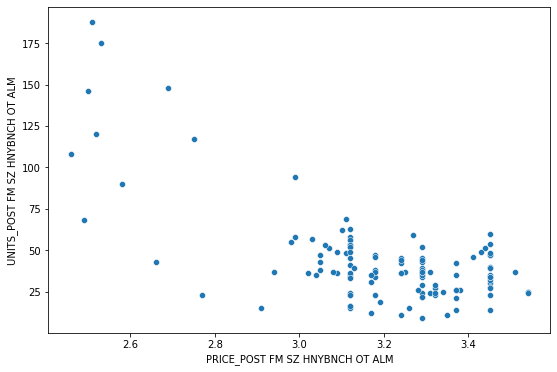

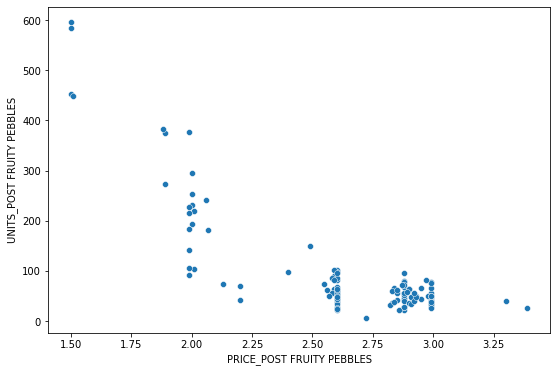

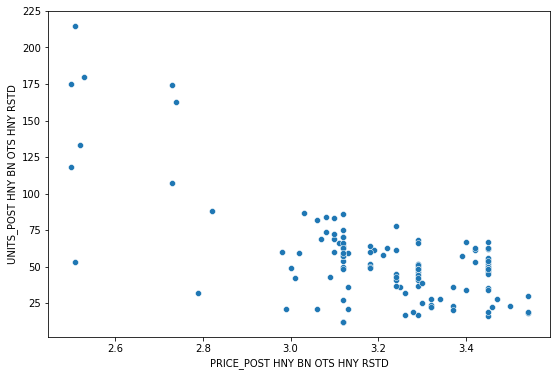

In [8]:
for item in items:
    price_col = "PRICE_" + item
    unit_col = "UNITS_" + item
    plt.figure(figsize=(9, 6))
    sns.scatterplot(x=price_col, y=unit_col, data=processed_df)

In [9]:
# 訓練データ，検証データに分割
train_df, test_df = train_test_split(
    processed_df, train_size=train_size, test_size=test_size, shuffle=False
)
test_df.reset_index(drop=True, inplace=True)

In [10]:
train_df.head()

,YEAR,MONTH,DAY,PRICE_POST FM SZ HNYBNCH OT ALM,PRICE_POST FRUITY PEBBLES,PRICE_POST HNY BN OTS HNY RSTD,UNITS_POST FM SZ HNYBNCH OT ALM,UNITS_POST FRUITY PEBBLES,UNITS_POST HNY BN OTS HNY RSTD
0,2009,7,8,3.29,2.6,3.29,9.0,41.0,50.0
1,2009,7,15,2.77,2.6,2.73,23.0,56.0,107.0
2,2009,7,22,3.29,2.6,3.29,22.0,50.0,41.0
3,2009,7,29,3.29,2.6,3.25,24.0,46.0,36.0
4,2009,8,5,3.29,2.6,3.29,34.0,57.0,52.0


In [11]:
test_df.head()

,YEAR,MONTH,DAY,PRICE_POST FM SZ HNYBNCH OT ALM,PRICE_POST FRUITY PEBBLES,PRICE_POST HNY BN OTS HNY RSTD,UNITS_POST FM SZ HNYBNCH OT ALM,UNITS_POST FRUITY PEBBLES,UNITS_POST HNY BN OTS HNY RSTD
0,2010,10,13,3.24,2.88,3.24,45.0,55.0,78.0
1,2010,10,20,3.18,2.88,3.18,47.0,45.0,60.0
2,2010,10,27,3.18,1.99,3.18,34.0,183.0,50.0
3,2010,11,3,3.18,2.82,3.18,37.0,32.0,52.0
4,2010,11,10,3.18,2.88,3.10,38.0,46.0,60.0


## 予測モデルの構築

In [12]:
# 学習データに対する予測モデルを構築
train_predictors = PredictorHandler(
    train_df=train_df,
    test_df=test_df,
    label2item=label2item,
    predictor_name=predictor_name,
    prefix="train",
)
train_predictors.run()  # 結果はdata/results/realworld/predict　に格納

# テストデータに対する予測モデルを構築
test_predictors = PredictorHandler(
    train_df=test_df,
    label2item=label2item,
    predictor_name=predictor_name,
    prefix="test",
)
test_predictors.run()  # 結果はdata/results/realworld/predict　に格納

[I 220829 00:36:52 predictor:123] RMSE for train data [POST FM SZ HNYBNCH OT ALM]: 19.0
[I 220829 00:36:52 predictor:127] R^2 for train data [POST FM SZ HNYBNCH OT ALM]: 0.58
[I 220829 00:36:53 predictor:123] RMSE for test data [POST FM SZ HNYBNCH OT ALM]: 27.8
[I 220829 00:36:53 predictor:127] R^2 for test data [POST FM SZ HNYBNCH OT ALM]: -0.01
[I 220829 00:36:53 predictor:123] RMSE for train data [POST FRUITY PEBBLES]: 59.9
[I 220829 00:36:53 predictor:127] R^2 for train data [POST FRUITY PEBBLES]: 0.78
[I 220829 00:36:54 predictor:123] RMSE for test data [POST FRUITY PEBBLES]: 59.3
[I 220829 00:36:54 predictor:127] R^2 for test data [POST FRUITY PEBBLES]: 0.27
[I 220829 00:36:55 predictor:123] RMSE for train data [POST HNY BN OTS HNY RSTD]: 18.4
[I 220829 00:36:55 predictor:127] R^2 for train data [POST HNY BN OTS HNY RSTD]: 0.63
[I 220829 00:36:55 predictor:123] RMSE for test data [POST HNY BN OTS HNY RSTD]: 28.3
[I 220829 00:36:55 predictor:127] R^2 for test data [POST HNY BN OTS

<Figure size 432x288 with 0 Axes>

In [13]:
train_predictors.result

defaultdict(<function src.predict.predictor.PredictorHandler.__init__.<locals>.<lambda>()>,
            {'rmse': defaultdict(dict,
                         {'train': {'POST FM SZ HNYBNCH OT ALM': 19.0,
                           'POST FRUITY PEBBLES': 59.9,
                           'POST HNY BN OTS HNY RSTD': 18.4,
                           'mean': 32.43},
                          'test': {'POST FM SZ HNYBNCH OT ALM': 27.8,
                           'POST FRUITY PEBBLES': 59.3,
                           'POST HNY BN OTS HNY RSTD': 28.3,
                           'mean': 38.47}}),
             'r2': defaultdict(dict,
                         {'train': {'POST FM SZ HNYBNCH OT ALM': 0.58,
                           'POST FRUITY PEBBLES': 0.78,
                           'POST HNY BN OTS HNY RSTD': 0.63,
                           'mean': 0.66},
                          'test': {'POST FM SZ HNYBNCH OT ALM': -0.01,
                           'POST FRUITY PEBBLES': 0.27,
            